<a href="https://colab.research.google.com/github/VladimirKrutko/My_projects/blob/master/test_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import numpy as np 
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [94]:
print(torch.cuda.is_available())

True


In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [96]:
softmax = nn.Softmax(dim=1)
x_input = torch.rand(3,3)
y_output = softmax (x_input)
print(x_input)
print(y_output)
print(torch.sum(y_output, dim=1))

tensor([[0.4109, 0.0255, 0.2664],
        [0.6642, 0.9862, 0.5744],
        [0.6582, 0.0802, 0.2058]])
tensor([[0.3928, 0.2672, 0.3400],
        [0.3036, 0.4189, 0.2775],
        [0.4552, 0.2553, 0.2895]])
tensor([1., 1., 1.])


In [97]:
mse = nn.MSELoss()
input = torch.rand(3,5, requires_grad=True)
output = torch.rand(3,5)
mse(input, output)

tensor(0.2195, grad_fn=<MseLossBackward>)

In [98]:
data = pd.read_csv('/content/google.csv')

In [99]:
for_model = data.drop(columns=['Unnamed: 0', 'title'])

In [100]:
X_lin = for_model.drop(columns=['ratingValue', 'label']).values

In [101]:
conv = {1:0,
2:1,
3:2,
4:3}

1:0
2:1
3:2
4:3

In [102]:
for_model.label = for_model.label.map(conv)

In [103]:
for_model.label.value_counts()

0    700
1    434
2    136
3     32
Name: label, dtype: int64

In [104]:
Y_num = for_model.label.values
X_num = for_model.drop(columns=['label', 'ratingValue']).values

In [105]:
# from plotly.offline import iplot, init_notebook_mode
# import plotly.graph_objs as graph
import matplotlib.pyplot as plt
# import plotly.express as px
# offline.init_notebook_mode()

<BarContainer object of 4 artists>

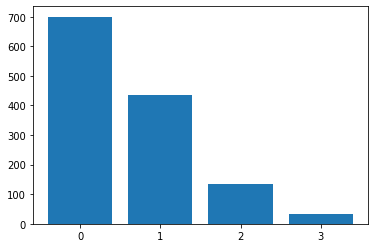

In [106]:
fig, ax = plt.subplots()
ax.bar(list(map(str,list(for_model.label.value_counts().index))), 
       list(for_model.label.value_counts().values),)

In [107]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_num, Y_num, test_size=0.2, stratify=Y_num, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)


In [108]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [109]:
class Cafe_Data(Dataset):
  def __init__(self, X, y):
    """
    X - матрица признаков в формате torch.Tensor
    y - список целевых меток класса
    """
    self.X = X
    self.y = y

  def __getitem__(self, index):
    imtems = {
        "X": self.X[index],
        "y": self.y[index]
    }
    return imtems
  def __len__(self):
    return self.X.shape[0]

In [110]:
train_dataset = Cafe_Data(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = Cafe_Data(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = Cafe_Data(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [111]:
def get_class_distribution(obj):
    count_dict = {
        "rating_0": 0,
        "rating_1": 0,
        "rating_2": 0,
        "rating_3": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_0'] += 1
        elif i == 1: 
            count_dict['rating_1'] += 1
        elif i == 2: 
            count_dict['rating_2'] += 1
        elif i == 3: 
            count_dict['rating_3'] += 1
            
    return count_dict

In [112]:
target_list = []
for i in range(len(train_dataset)):
    target_list.append(train_dataset[i]['y'])
# print(target_list)
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

class_weights_all = class_weights[target_list]

weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [113]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X_num[0])
NUM_CLASSES = 4

In [114]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [115]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [116]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to('cuda')

criterion = nn.CrossEntropyLoss(weight=class_weights.to('cuda'))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [117]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [118]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


In [119]:
from tqdm.notebook import tqdm

In [120]:
for e in tqdm(range(1,EPOCHS+1)):
  #Trainig 
  train_epoch_loss = 0 
  train_epoch_acc = 0 
  model.train()
  for data in train_loader:
    # GEt data
    X_train_batch, y_train_batch = data['X'].to("cuda"), data['y'].to('cuda')
    # Zero optimizer
    optimizer.zero_grad()
    # Make predict
    y_train_pred = model(X_train_batch)
    # Calculate loss
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)

    # Use loss value
    train_loss.backward()
    optimizer.step()

    train_epoch_loss +=train_loss.item()
    train_epoch_acc += train_acc.item()

  # Validation data
  with torch.no_grad():

    val_epoch_loss =0 
    val_epoch_acc = 0

    model.eval()
    for val_data in val_loader:
      X_val_batch, y_val_batch = data['X'].to('cuda'), data['y'].to('cuda')
      y_val_pred = model(X_val_batch)

      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = multi_acc(y_val_pred, y_val_batch)

      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()
  
  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

    

 

Epoch 001: | Train Loss: 1.33429 | Val Loss: 1.22546 | Train Acc: 10.169| Val Acc: 0.000
Epoch 002: | Train Loss: 1.08250 | Val Loss: 0.77091 | Train Acc: 50.847| Val Acc: 100.000
Epoch 003: | Train Loss: 0.95436 | Val Loss: 1.63816 | Train Acc: 77.966| Val Acc: 100.000
Epoch 004: | Train Loss: 0.93956 | Val Loss: 0.43747 | Train Acc: 77.966| Val Acc: 0.000
Epoch 005: | Train Loss: 0.89449 | Val Loss: 0.51543 | Train Acc: 84.746| Val Acc: 100.000
Epoch 006: | Train Loss: 0.80142 | Val Loss: 0.77425 | Train Acc: 88.136| Val Acc: 100.000
Epoch 007: | Train Loss: 0.79906 | Val Loss: 0.87784 | Train Acc: 86.441| Val Acc: 100.000
Epoch 008: | Train Loss: 0.80997 | Val Loss: 0.64275 | Train Acc: 88.136| Val Acc: 100.000
Epoch 009: | Train Loss: 0.71558 | Val Loss: 0.56787 | Train Acc: 89.831| Val Acc: 100.000
Epoch 010: | Train Loss: 0.75094 | Val Loss: 0.69768 | Train Acc: 94.915| Val Acc: 100.000
Epoch 011: | Train Loss: 0.68046 | Val Loss: 0.36872 | Train Acc: 91.525| Val Acc: 100.000
Epo

In [121]:
import seaborn as sns

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

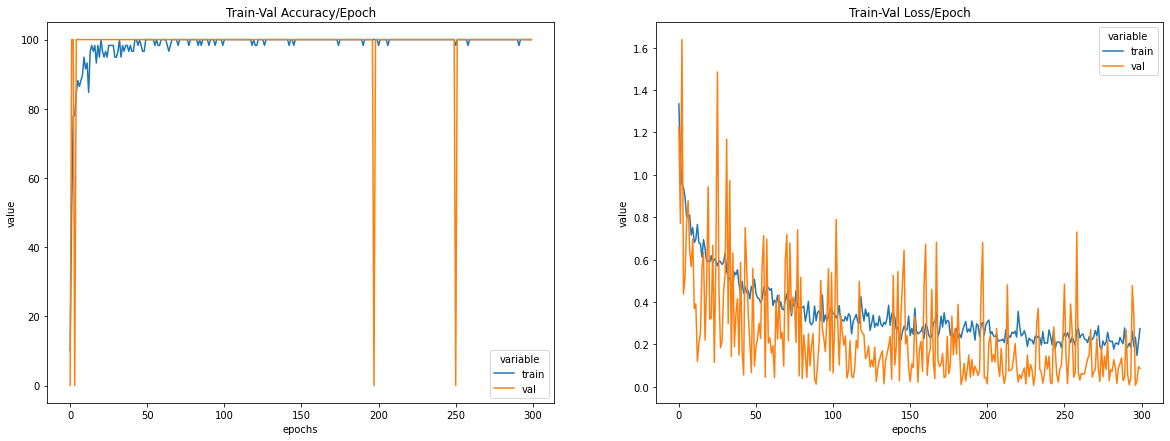

In [122]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [123]:
model.eval()
y_neir = model(torch.from_numpy(X_num[:200]).float().to('cuda')).max(0)

In [124]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for data in test_loader:
        X_batch = data['X'].to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [125]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [126]:
rand_forest = RandomForestClassifier(n_jobs=-1)
rand_forest.fit(X_train, y_train)
forest_pred = rand_forest.predict(X_test)

Text(0.5, 1.0, 'NN matrix')

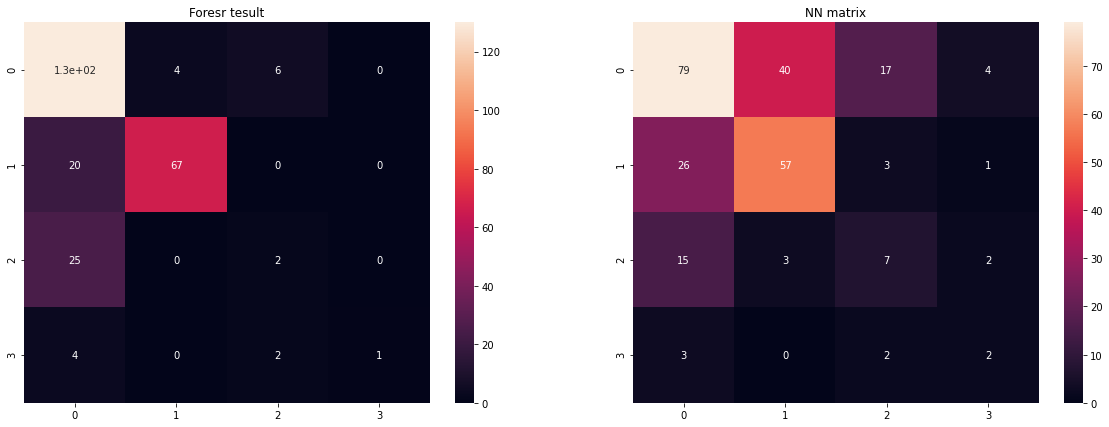

In [127]:
confusion_forest = pd.DataFrame(confusion_matrix(y_test,forest_pred))
confusion_nn = pd.DataFrame(confusion_matrix(y_test, y_pred_list))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.heatmap(confusion_forest, annot=True, ax=axes[0]).set_title('Foresr tesult')
sns.heatmap(confusion_nn, annot=True, ax=axes[1]).set_title('NN matrix')

In [128]:
print(f"Forest classification report \n{classification_report(forest_pred, y_test)}")
print(f"NN classification report \n{classification_report(y_pred_list, y_test)}")

Forest classification report 
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       179
           1       0.77      0.94      0.85        71
           2       0.07      0.20      0.11        10
           3       0.14      1.00      0.25         1

    accuracy                           0.77       261
   macro avg       0.48      0.72      0.51       261
weighted avg       0.85      0.77      0.79       261

NN classification report 
              precision    recall  f1-score   support

           0       0.56      0.64      0.60       123
           1       0.66      0.57      0.61       100
           2       0.26      0.24      0.25        29
           3       0.29      0.22      0.25         9

    accuracy                           0.56       261
   macro avg       0.44      0.42      0.43       261
weighted avg       0.56      0.56      0.55       261



In [129]:
test = pd.DataFrame( for_model.iloc[0]).T.copy()

In [130]:
test.iloc[:, 37:47] = [ i for i in range(1,11)]

In [131]:
test.iloc[:, 37:47]

,confectionary,sushi,supermarket,malls,restaurants,fallback services,fast food,cafe,bars,concert hall
0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0


In [132]:
test.iloc[:, 56:65]

,facebook,instagram,twitter,telegram,viber,whatsapp,ok,vkontakte,youtube
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
def calc_eval(bit_string, index, opt_elem):
  data = 


SyntaxError: ignored

In [134]:
! pip install deap

In [135]:
from deap import  base
from deap import  creator
from deap import tools
import random

In [136]:
ONE_MAX_LENGTH = 19
POPULATIN_SIZE = 100
P_CROSSVER = 0.9
P_MUTATION = 0.1
MAX_GENERATIONS = 50 

In [137]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [138]:
toolbox = base.Toolbox()
# Funck of generate vakue
toolbox.register("zeroOrOne", random.randint, 0,1)

In [139]:
# Fucnl for optimize 
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [140]:
# Funck for creati type of indiwiduals and conteiners
creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [141]:
# Funck for create individuals
toolbox.register('individualCreator', tools.initRepeat, 
                 creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGHT)

In [142]:
# Create list of individuals(populations)
toolbox.register("populationCreator", tools.initRepeat,
                list, toolbox.individualCreator)

In [143]:
#  Funck for get a marks of fitness
def oneMaxFitness(individual):
  return sum(individual), 

# registr evaluate funck in deap
toolbox.register("evaluate", oneMaxFitness)

In [161]:
# Create type of select ex from population 
toolbox.register('select', tools.selTournament,  tournsize=3)
toolbox.register('mate', tools.cxOnePoint)
toolbox.register('mutate', tools.mutFlipBit,  indpb=1.0/ONE_MAX_LENGTH)

Начинаем реализовывать алгоритм. Создаём началбную популяцию 

In [152]:
population = toolbox.populationCreator(n=POPULATIN_SIZE)
generationCounter = 0

Вычисляем приспособленность 

In [146]:
fitnessValues = list(map(toolbox.evaluate, population))

Объеденим занчение индивидов  с их оценкой

In [147]:
for individ, fitVal in zip(population, fitnessValues):
  individ.fitness.values = fitVal

Извлечём первые значение для статистики 

In [148]:
fitnessValues = [individ.fitness.values[0] for individ in population]

In [149]:
maxFitnessValues = []
meanFitnessValues = []

Сейяас будем писать основной алгорти и перед каждым запуском алгоритма будем проверять условие  проверки 

In [163]:
while max(fitnessValues) <ONE_MAX_LENGHT and generationCounter < MAX_GENERATIONS:
      generationCounter +=1
      # Сейчас будет сердце алгортима. Применяем оператор отбора 
      offspring = toolbox.select(population, len(population))
      # Create a copy of thos list for next operatons 
      offspring = list(map(toolbox.clone, offspring))

      # Make breeding. Even element breeding with next not breeding element 
      for ch1, ch2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSVER:
          toolbox.mate(ch1, ch2)
          del ch1.fitness.values
          del ch2.fitness.values
      # Make a mutation whith propobility P_MUTATION
      for mutant in offspring:
        if random.random()<P_MUTATION:
          toolbox.mutate(mutant)
          del mutant.fitness.values
      # looking for new element with out valid
      freshInd = [ind for ind in offspring if not ind.fitness.valid]
      freshFitVal = list(map(toolbox.evaluate, freshInd))
      for ind , fitVal in zip(freshInd, freshFitVal):
        ind.fitness.values = fitVal
      # We using all genetics operations replace old values of populations
      #  on new values of populations
      population[:] = offspring
      # Save a value of eval 
      fitnessValues = [ind.fitness.values[0] for ind in population]
      # Calculate max and mean values 
      maxFitness = max(fitnessValues)
      meanFitness = sum(fitnessValues) / len(population)
      maxFitnessValues.append(maxFitness)
      meanFitnessValues.append(meanFitness)
      print(" Поколение{}: Макс приспособ ={} , Сред приспособ = {}".
            format(generationCounter, maxFitness, meanFitness))
      t_index = fitnessValues.index(max(fitnessValues))
      print("Лучший индивид = ", *population[t_index], '\n')
      







 Поколение8: Макс приспособ =15.0 , Сред приспособ = 9.4
Лучший индивид =  1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 

 Поколение9: Макс приспособ =16.0 , Сред приспособ = 11.18
Лучший индивид =  1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 

 Поколение10: Макс приспособ =16.0 , Сред приспособ = 12.74
Лучший индивид =  1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 

 Поколение11: Макс приспособ =17.0 , Сред приспособ = 14.08
Лучший индивид =  1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

 Поколение12: Макс приспособ =19.0 , Сред приспособ = 15.19
Лучший индивид =  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



In [ ]:
class GA_Optimuze:  
  def __init__(self, index=None, string, rating):

    if index:
      self.data_str = pd.DataFrame(for_model.iloc[index]).T
    else:
      self.data_str = string
    self.rating = rating
    self.ONE_MAX_LENGTH = 19
    self.POPULATIN_SIZE = 100
    self.P_CROSSVER = 0.9
    self.P_MUTATION = 0.1
    self.MAX_GENERATIONS = 50
    self.RANDOM_SEED = 42
    random.seed(RANDOM_SEED)
    self.toolbox = base.Toolbox()
    self.toolbox.register("zeroOrOne", random.randint, 0,1)
    self.creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    self.creator.create("Individual", list, fitness=creator.FitnessMax)
    self.toolbox.register('individualCreator', tools.initRepeat, 
                 creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGHT)
    self.toolbox.register("evaluate", self.calc_eval)
    self.toolbox.register('select', tools.selTournament,  tournsize=3)
    self.toolbox.register('mate', tools.cxOnePoint)
    self.toolbox.register('mutate', tools.mutFlipBit,  indpb=1.0/ONE_MAX_LENGTH)

    
    




    
  def calc_eval(self, individ):
    self.data_str.iloc[:, 37:47], self.data_str.iloc[:,56:65] = individ[:10], individ[11:] 
    probobility = rand_forest.predict_proba(self.data_str)
    return probobility[self.rating]

  

  
    

    

